In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
def find_last_valid_record(df):
    '''Find the first row where all columns are null, and return the row previous to that.'''

    last_record_idx = df.isnull().apply(lambda x: all(x), axis=1).idxmax() - 1
    
    return last_record_idx


In [3]:
fname = "corporate sponsors 2022.xlsx"
#df = pd.read_excel(fname, sheet_name = '2010')

colnames = [ 'Added/   Modified', 	'Company Name',	'Sponsorship level'	,
             '$ Amount', 'Actual \n$ Amount',	'Money/Prize Received',  'Prize/Donation details' ]


In [5]:
def process_year_donations(main_fname: str, year:str, colnames: list):
    df = pd.read_excel(main_fname, sheet_name = year)

    # we deduce if the column headers are in the first or second row. If necessary, we correct the read of the file
    c = 0
    for i in df.columns[:20]:
        if 'Unnamed:' in str(i):
            c += 1
    if c > 8 :
        df = pd.read_excel(main_fname, sheet_name = year, header = 1)

    last_record_idx = find_last_valid_record(df)
    df = df.iloc[:last_record_idx]

    df = df[df.columns & colnames].copy()

    #df['Added/   Modified'] = pd.to_datetime(df['Added/   Modified'])

    if 'Prize/Donation details' in df.columns:
        df['Donation details'] = df['Prize/Donation details']
    else:
        df['Donation details'] = df['Sponsorship level']
    
    df = df.drop(columns = ['Sponsorship level'	,'Prize/Donation details'], errors = 'ignore')
    
    df = df.rename(columns = {'Actual \n$ Amount':'$ Amount'})

    df = df.reset_index(drop=True)

    return df



In [6]:
years = [str(i) for i in range(2010,2023,1)]

In [7]:
df_concat = process_year_donations(fname, years[0], colnames)[:0] # we just take the structure

for y in years:
    df_ = process_year_donations(fname, y, colnames)
    print(y , df_.shape , '\n')
    df_['Year'] = y 
    df_concat = pd.concat( [df_concat, df_])

df_concat = df_concat.reset_index(drop=True)



2010 (80, 5) 

2011 (86, 5) 

2012 (84, 5) 

2013 (93, 5) 

2014 (140, 5) 

2015 (149, 5) 

2016 (133, 5) 

2017 (103, 5) 

2018 (77, 5) 

2019 (56, 5) 

2020 (29, 5) 

2021 (33, 5) 

2022 (15, 5) 



In [106]:
df_concat[df_concat.year == '2017'][['company_name', 'dollar_amount']].isna().all(1)

765    False
766    False
767    False
768    False
769    False
       ...  
863     True
864     True
865     True
866     True
867     True
Length: 103, dtype: bool

,Added/ Modified,Company Name,$ Amount,Money/Prize Received,Donation details,Year
0,2019-01-01 00:00:00,VIA,0,NaN,trip for 4 Montreal/Windsor $2600 value,2010
1,2019-01-01 00:00:00,Ultramar,500,yes,Silver - $500 in gas coupons,2010
2,2019-01-01 00:00:00,Fondation BBB,5000,yes,Platinum,2010
3,2019-01-01 00:00:00,Sleeman Unibroue Inc.,0,NaN,beer,2010
4,2020-01-01 00:00:00,Friends of Trouser Lake,500,NaN,Mike will look into ad,2010
...,...,...,...,...,...,...
1073,2022-02-23 00:00:00,Lorne Steinberg Wealth Management,2000.0,NaN,"$2,000 Silver Sponsorship",2022
1074,2022-02-23 00:00:00,"BMA - Brais, Malouin et Associés inc",2000.0,Yes,Corporate team,2022
1075,2021-12-18 00:00:00,Hemmingford Golf Club,0.0,NaN,NaN,2022
1076,NaN,Magie de l'air,0.0,NaN,NaN,2022


In [10]:
import re
cols = df_concat.columns.to_list()
new_cols=[]
for col in cols:
    
    col = re.sub(' +', ' ', col)
    col = col.replace(' ','_')
    col = col.replace('/','')
    col = col.replace('$','dollar')
    col = col.lower()
    new_cols.append(col)

df_concat.columns = new_cols

### Formatting Date

In [11]:
df_concat.added_modified = df_concat.added_modified.astype(str)

In [12]:
df_concat.added_modified.str[4:5].value_counts()

#df_concat.added_modified.str[7:8].value_counts()

-    976
      65
5      8
4      8
1      6
9      4
/      3
2      2
3      2
7      2
6      2
Name: added_modified, dtype: int64

In [13]:
date_format_flg = (df_concat.added_modified.str[4:5] == '-') & (df_concat.added_modified.str[7:8] == '-')

In [41]:
df_concat['2010_day'] = df_concat[date_format_flg & (df_concat.year=='2010')].added_modified.str[2:4]
df_concat['2010_month'] = df_concat[date_format_flg & (df_concat.year=='2010')].added_modified.str[5:7]


## try to give the correct date format to added_modified. Older years seem to have only month/day 
## but most recent have also year, so a criteria has to be set to correctly parse 

In [53]:
df_concat.loc[date_format_flg & (df_concat.year=='2010'), 'added_modified'] = \
df_concat[date_format_flg & (df_concat.year=='2010')]['year'] + '-'\
+ df_concat[date_format_flg & (df_concat.year=='2010')]['2010_month'] + '-' \
+ df_concat[date_format_flg & (df_concat.year=='2010')]['2010_day'] 


In [54]:
df_concat[date_format_flg & (df_concat.year=='2010')]

,added_modified,company_name,dollar_amount,moneyprize_received,donation_details,year,2010_day,2010_month
0,2010-01-19,VIA,0,NaN,trip for 4 Montreal/Windsor $2600 value,2010,19,01
1,2010-01-19,Ultramar,500,yes,Silver - $500 in gas coupons,2010,19,01
2,2010-01-19,Fondation BBB,5000,yes,Platinum,2010,19,01
3,2010-01-19,Sleeman Unibroue Inc.,0,NaN,beer,2010,19,01
4,2010-01-20,Friends of Trouser Lake,500,NaN,Mike will look into ad,2010,20,01
...,...,...,...,...,...,...,...,...
72,2010-03-03,Second Cup - St. Hubert,200,Yes,$200 1/4 page ad plus coffee for clubs,2010,03,03
73,2010-03-03,L'Etoile de St-Hilaire,100,Yes,business card,2010,03,03
74,2010-03-03,Nakisa,500,Yes,$500 silver ad,2010,03,03
75,2010-03-06,Ville d'Otterburn Park,100,Yes - Tom has it,100,2010,06,03


In [57]:
df_concat = df_concat.drop(columns= [ '2010_day', '2010_month'])

In [61]:
df_concat['added_modified_clean'] = pd.to_datetime(df_concat.added_modified, errors = 'coerce')

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt


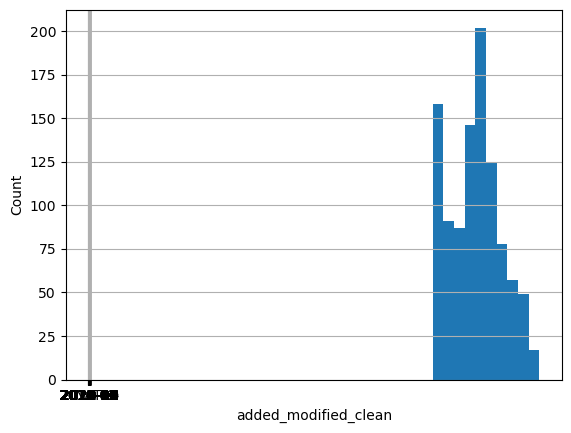

In [81]:
sns.histplot(month_periods.astype(str))
plt.show()

In [116]:
# clean some rows that are all empty
df_concat = df_concat [ ~df_concat[['company_name', 'dollar_amount','moneyprize_received','donation_details']].isna().all(1) ].copy()

In [120]:
df_concat.added_modified_clean

0      2010-01-19
1      2010-01-19
2      2010-01-19
3      2010-01-19
4      2010-01-20
          ...    
1073   2022-02-23
1074   2022-02-23
1075   2021-12-18
1076          NaT
1077   2022-02-23
Name: added_modified_clean, Length: 1029, dtype: datetime64[ns]

In [136]:
month_periods = df_concat.added_modified_clean.dt.to_period('M').astype(str)

In [154]:
month_counts = month_periods.value_counts().rename_axis('year_month').reset_index()

In [155]:
month_counts = month_counts.sort_values('year_month')

In [156]:
month_counts.year_month.str[5:]

13    01
7     02
37    03
49    12
17    01
      ..
50    01
42    02
60    03
48    06
16      
Name: year_month, Length: 79, dtype: object

In [157]:
month_counts['year'] = month_counts.year_month.str[:4]
month_counts['month'] = month_counts.year_month.str[5:]





In [167]:
pivot_month_counts = month_counts.pivot( "month", "year","added_modified_clean").fillna(0).astype(int)

In [171]:
pivot_month_counts = pivot_month_counts.drop(columns = ['NaT'])

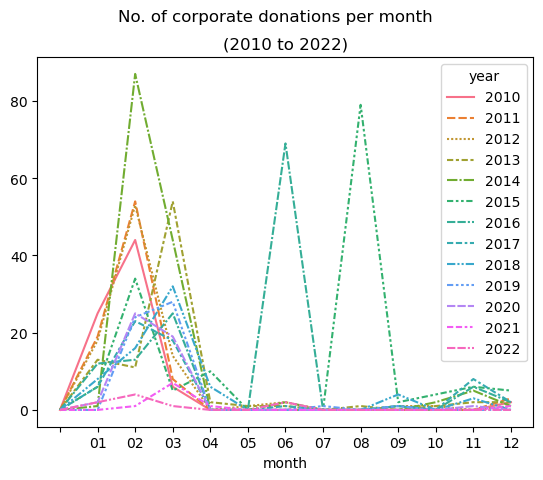

In [176]:
sns.lineplot(data = pivot_month_counts)
plt.suptitle('No. of corporate donations per month ')
plt.title('(2010 to 2022)')
plt.show()

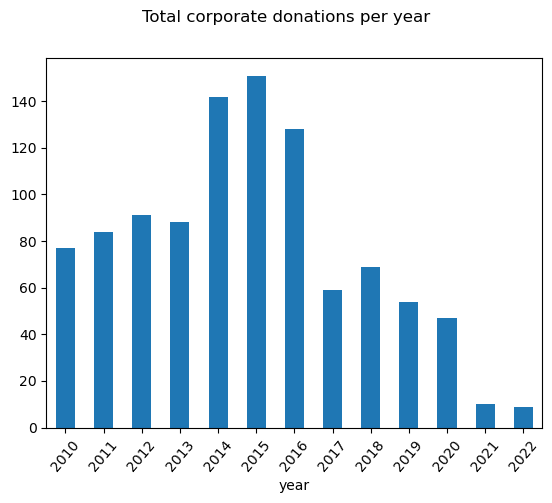

In [188]:
pivot_month_counts.sum().plot(kind = 'bar', rot = 50)
plt.suptitle('Total corporate donations per year')
plt.show()